In [7]:
import cv2
import os
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score, confusion_matrix
import csv
import matplotlib.pyplot as plt
import itertools

In [8]:
num_labels = 6
# random.seed(0)

In [9]:
def load_frames(vid_path):
    frames = []
    
    imgs = os.listdir(vid_path)
    for i in range(len(imgs)):
        # if i % 2 != 0:
        #     continue
        img_path = os.path.join(vid_path, imgs[i])
        frame = cv2.imread(img_path)

        frames.append(frame)

    return frames


def extract_optical_flow(frames):
    features = []

    # 初始化前一帧
    prev_frame = cv2.cvtColor(frames[0], cv2.COLOR_BGR2GRAY)

    for frame in frames[1:]:
        # 將當前帧轉換為灰度圖
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        # 計算光流
        flow = cv2.calcOpticalFlowFarneback(prev_frame, gray, None, 0.5, 3, 15, 3, 5, 1.2, 0)

        # 將光流的水平和垂直分量組合為特徵向量
        flow_feature = flow.reshape(-1)
        features.append(flow_feature)

        # 更新前一帧
        prev_frame = gray

    return np.array(features)


def preprocess(path, csv_path):
    vids = [[] for _ in range(num_labels)]
    with open(csv_path, 'r') as file:
        rows = csv.reader(file)
        for row in rows:
            vids[int(row[2])].append(os.path.join(row[1], row[0]))
            
    features = []
    labels = []

    for l in range(num_labels):

        for i in range(len(vids[l])):
            vid_path = os.path.join(path, vids[l][i])
            frames = load_frames(vid_path)
            optical_flow_features = extract_optical_flow(frames)
            # print(optical_flow_features.shape)
            features.append(optical_flow_features)
            labels.append(l)    

    return np.array(features), np.array(labels)

In [10]:
X, y = preprocess('./dataset', './dataset.csv')
print(X.shape, y.shape)

(234, 29, 28800) (234,)


In [11]:
# 將三維特徵數組轉換為二維
X_flat = X.reshape((X.shape[0], -1))

svm_model = SVC(kernel='linear', C=0.1)
predicted_labels = cross_val_predict(svm_model, X_flat, y, cv=5)

# 計算準確率
accuracy = accuracy_score(y, predicted_labels)
cnf_matrix_sklearn = confusion_matrix(y, predicted_labels)
print(f'Accuracy: {accuracy}')
print(cnf_matrix_sklearn)

Accuracy: 0.4658119658119658
[[21  7  1  1  6  3]
 [ 5 18  3  1  9  0]
 [ 3  9  5  0  8  8]
 [ 5  4  0 17  9  1]
 [ 0  7  1  3 31  2]
 [ 3  8  9  5  4 17]]


In [12]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Confusion matrix, without normalization
[[21  7  1  1  6  3]
 [ 5 18  3  1  9  0]
 [ 3  9  5  0  8  8]
 [ 5  4  0 17  9  1]
 [ 0  7  1  3 31  2]
 [ 3  8  9  5  4 17]]


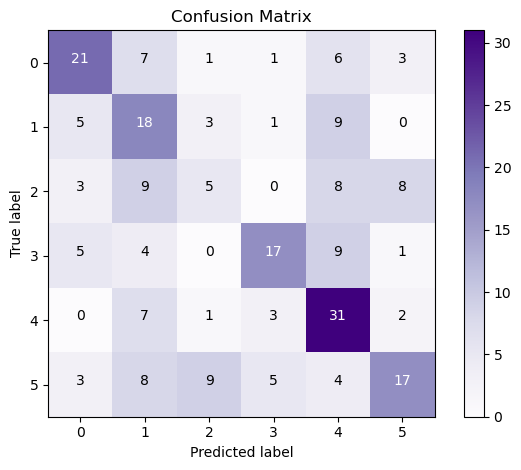

In [13]:
plot_confusion_matrix(cnf_matrix_sklearn, [0, 1, 2, 3, 4, 5], normalize=False, title='Confusion Matrix', cmap=plt.cm.Purples)

228
0.5087719298245614
Confusion matrix, without normalization
[[20  7  4  1  3  4]
 [ 9 19  1  1  6  0]
 [ 2  7 16  0  4  4]
 [ 1  5  0  9 14  1]
 [ 3  6  0  3 32  0]
 [ 3  7  9  3  4 20]]


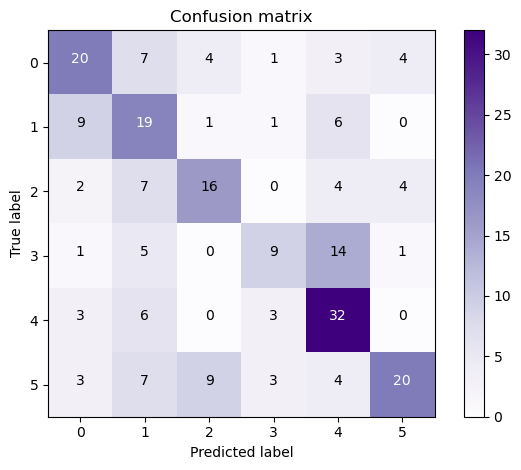

In [14]:
cnf = np.array([
    [3, 1, 1, 0, 1, 2],
    [3, 3, 0, 0, 2, 0],
    [0, 1, 4, 0, 1, 1],
    [0, 1, 0, 3, 2, 0],
    [0, 0, 0, 1, 8, 0],
    [1, 2, 2, 1, 0, 4]
]) + np.array([
    [4, 2, 1, 0, 1, 0],
    [4, 3, 0, 0, 0, 0],
    [1, 0, 3, 0, 0, 3],
    [0, 2, 0, 3, 1, 0],
    [0, 2, 0, 0, 7, 0],
    [0, 0, 3, 1, 0, 5]
]) + np.array([
    [3, 1, 2, 0, 1, 1],
    [2, 3, 0, 0, 2, 0],
    [0, 1, 5, 0, 1, 0],
    [0, 0, 0, 1, 5, 0],
    [0, 1, 0, 0, 8, 0],
    [0, 0, 0, 0, 3, 6]
]) + np.array([
    [6, 1, 0, 0, 0, 1],
    [0, 6, 0, 1, 0, 0],
    [0, 3, 2, 0, 1, 0],
    [0, 0, 0, 1, 4, 1],
    [1, 3, 0, 1, 4, 0],
    [2, 2, 2, 1, 0, 2]
]) + np.array([
    [4, 2, 0, 1, 0, 0],
    [0, 4, 1, 0, 2, 0],
    [1, 2, 2, 0, 1, 0],
    [1, 2, 0, 1, 2, 0],
    [2, 0, 0, 1, 5, 0],
    [0, 3, 2, 0, 1, 3]
])

s = sum(sum(cnf))
print(s)

correct = 0
for i in range(6):
    correct = correct + cnf[i][i]

print(correct / s)
plot_confusion_matrix(cnf, [0, 1, 2, 3, 4, 5], cmap=plt.cm.Purples)